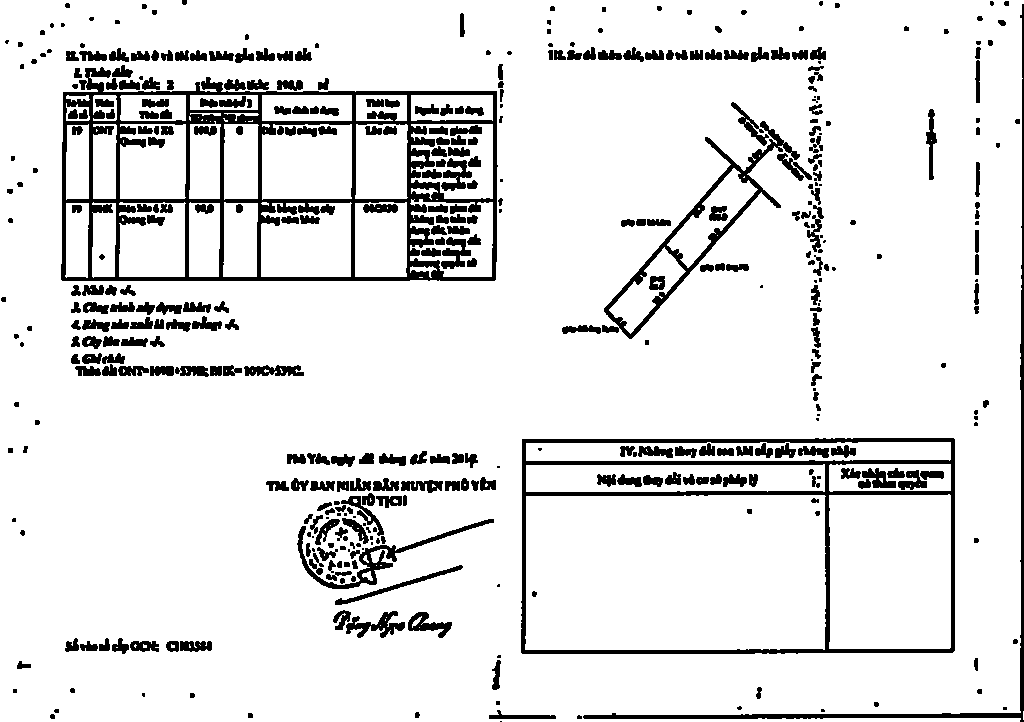

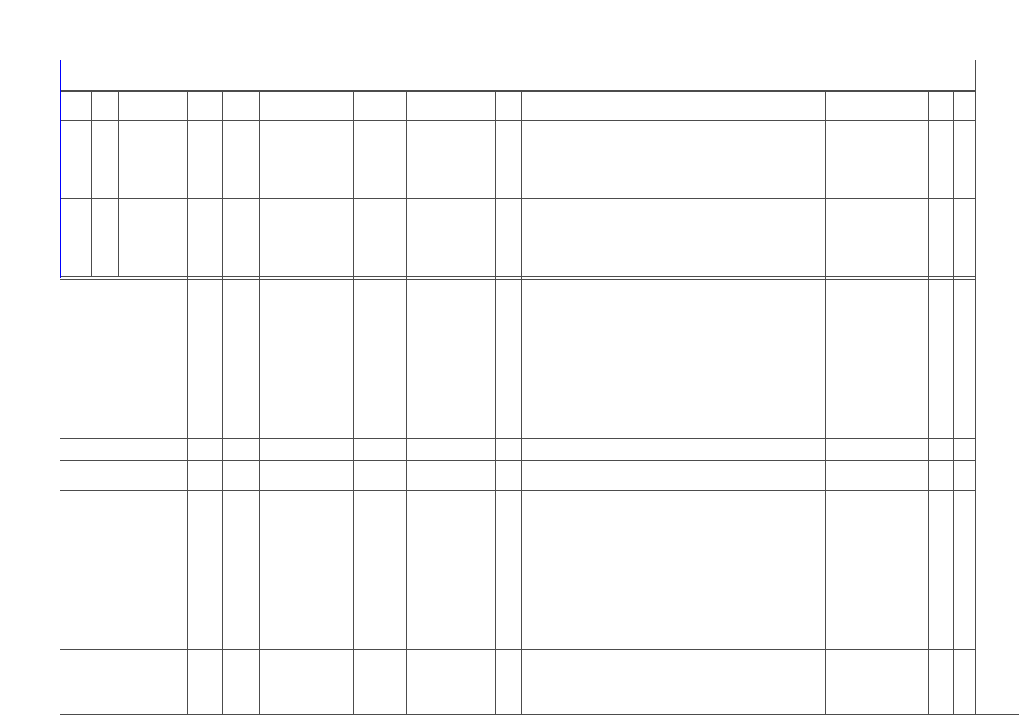

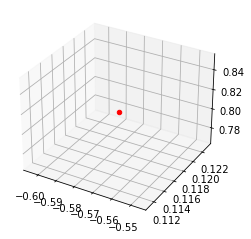

In [31]:
from __future__ import print_function # Only Python 2.x
from pdf2image import convert_from_path, convert_from_bytes
import subprocess
import numpy as np
import cv2
from os import walk
import math
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imutils
from imutils import contours
from imutils import perspective

def inverte(img):
    return (255-img)

def canny_edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    img_gaussian = cv2.GaussianBlur(img, (blur_ksize, blur_ksize), 0)
    img_canny = cv2.Canny(img_gaussian, threshold1, threshold2)
    return img_canny

def getImagesFromPDFPath(path):
    imgs = convert_from_path(path, fmt="png", size=(512, None), grayscale=True)
    return imgs

def loadImage(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def listFile(path):
    return next(walk(path), (None, None, []))[2]  # [] if no file

# def getTemplates(path):
#     templates = []
#     for name in listFile("papers/templates/"):

def transposeLines(lines):
    lines2 = []
    for line in lines:
        lines2.append([[line[0][1], line[0][0], line[0][3], line[0][2]]])
    return lines2

def mergeHorizonalLines(horLines, gap=(50, 50)):
    horLines = sorted(horLines, key=lambda x: x[0][1]) # sort by y0
    
    i, i1 = 0, 1
    mergedTrigger = False
    while True:
        if i >= len(horLines):
            if mergedTrigger:
                i, i1 = 0, 1
                mergedTrigger = False
                continue
            else:
                break
        if i1 >= len(horLines):
            i, i1 = i+1, i+2
            continue
        x00, y00, x01, y01 = horLines[i][0][0], horLines[i][0][1], horLines[i][0][2], horLines[i][0][3]
        x10, y10, x11, y11 = horLines[i1][0][0], horLines[i1][0][1], horLines[i1][0][2], horLines[i1][0][3]
        minX = x00 if x00 < x10 else x10
        maxX = x01 if x01 > x11 else x11
        l1, l2 = abs(x00-x01), abs(x10-x11)
        closeY = abs(y00 - y10) < gap[1]
        closeX = l1 + l2 + gap[0] >= maxX - minX
        if not closeY:
            i, i1 = i+1, i+2
            continue
        if not closeX:
            i, i1 = i, i1+1
            continue
        if l1 > l2:
            horLines[i] = [[minX, y00, maxX, y00]]
            del horLines[i1]
        else:
            horLines[i] = [[minX, y10, maxX, y10]]
            del horLines[i1]
        mergedTrigger = True
    return horLines

def connectCheckHorLineInGroup(l, group, minXmaxXGroup, verLines, gapX):
    x00, y00, x01, y01 = l[0][0], l[0][1], l[0][2], l[0][3]
    for line in group:
        x10, y10, x11, y11 = line[0][0], line[0][1], line[0][2], line[0][3]
        minX = x00 if x00 < x10 else x10
        maxX = x01 if x01 > x11 else x11
        minY = y00 if y00 < y10 else y10
        maxY = y00 if y00 > y10 else y10
        l1, l2 = abs(x00-x01), abs(x10-x11)
        closeX = l1 + l2 + gapX >= maxX - minX
        if closeX:
            hasBetweenVerLine = False
            for j in range(len(verLines)):
                x20, y20, x21, y21 = verLines[j][0][0], verLines[j][0][1], verLines[j][0][2], verLines[j][0][3]
                minY2 = minY if minY < y20 else y20
                maxY2 = maxY if maxY > y21 else y21
                between2HorLinesX = x20 >= minX - gapX and x20 <= maxX + gapX
                between2HorLinesY = abs(minY - maxY) + abs(y20 - y21) > abs(minY2 - maxY2)
                if between2HorLinesX and between2HorLinesY:
                    hasBetweenVerLine = True
                    verLines[j] = [[x20, minY2, x21, maxY2]]
            if hasBetweenVerLine:
                group.append(l)
                minX3 = x00 if x00 < minXmaxXGroup[0] else minXmaxXGroup[0]
                maxX3 = x10 if x10 > minXmaxXGroup[1] else minXmaxXGroup[1]
                minXmaxXGroup = [minX3, maxX3]
                return group, minXmaxXGroup, verLines, True
    return group, minXmaxXGroup, verLines, False

def parseHorLines(horLines, verLines, gapX):
    horLines = sorted(horLines, key=lambda x: x[0][1]) # sort by y0
    verLines = sorted(verLines, key=lambda x: x[0][0]) # sort by x0
    
    groups = []
    minXmaxXGroups = []
    for i in range(len(horLines)):
        collected = False
        for j in range(len(groups)):
            groups[j], minXmaxXGroups[j], verLines, result = connectCheckHorLineInGroup(horLines[i], \
                                                            groups[j], minXmaxXGroups[j], verLines, gapX)
            if result:
                collected = True
                break
        if not collected:
            groups.append([horLines[i]])
            minXmaxXGroups.append([horLines[i][0][0], horLines[i][0][2]])
    
    for i in range(len(groups)):
        for j in range(len(groups[i])):
            groups[i][j] = [minXmaxXGroups[i][0], groups[i][j][0][1], minXmaxXGroups[i][1], groups[i][j][0][1]]
    return groups, verLines

def connectLines(horLines, verLines, gap=(30, 30)):
    # connect horizonal lines
    verLines = sorted(verLines, key=lambda x: x[0][0]) # sort by x0
    for i in range(len(horLines)):
        for j in range(len(verLines)):
            x00, y00, x01, y01 = horLines[i][0][0], horLines[i][0][1], horLines[i][0][2], horLines[i][0][3]
            x10, y10, x11, y11 = verLines[j][0][0], verLines[j][0][1], verLines[j][0][2], verLines[j][0][3]
            closeLeftX = abs(x00 - x10) < gap[0]
            closeRightX = abs(x01 - x11) < gap[0]
            closeX = closeLeftX or closeRightX
            closeTopY = y00 <= y10 + gap[1]
            closeBottomY = y00 >= y11 - gap[1]
            closeY = closeTopY or closeBottomY
            if closeX and closeY:
                if closeLeftX:
                    x00 = min(x00, x10)
                if closeRightX:
                    x01 = max(x01, x10)
                if closeTopY and abs(y00 - y10) <= gap[1]:
                    y10 = max([y00, y10])
                if closeBottomY and abs(y00 - y11) <= gap[1]:
                    y11 = min([y00, y11])
                horLines[i] = [[x00, y00, x01, y01]]
                verLines[j] = [[x10, y10, x11, y11]]
    return horLines, verLines

def extractImage(path):
    # read image
    img = cv2.imread(path, 0)
    # resize
    height, width = img.shape
    fix_width = 1024
    img = cv2.resize(img, (fix_width, int(height*fix_width/width)), interpolation = cv2.INTER_AREA)
    # edge and proccess
#     img = canny_edge_detection(img, 1, 50, 100)
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#     img = cv2.dilate(img, None, iterations = 1)
    img2 = cv2.erode(img, np.ones((2, 2), np.uint8))
#     img = cv2.GaussianBlur(img, (5,5), 0)
    display(Image.fromarray(img2))
#     img = inverte(img)
    # declare line detector
    fld = cv2.ximgproc.createFastLineDetector()
    lines = fld.detect(img)
    # filter
    horLines = []
    verLines = []
    for line in lines:
        # filter by length
        x0 = line[0][0]
        y0 = line[0][1]
        x1 = line[0][2]
        y1 = line[0][3]
        length = math.sqrt(pow(abs(x0 - x1), 2) + pow(abs(y0 - y1), 2))
        if length < fix_width*0.03 or length > fix_width*0.8:
            continue
        # filter by angle
        xd = abs(x0 - x1)
        yd = abs(y0 - y1)
        if xd < 1:
            verLines.append([[x0, y0, x0, y1]]) # convert to vertical or horizonal
            continue
        elif yd < 1:
            horLines.append([[x0, y0, x1, y0]]) # convert to vertical or horizonal
            continue
        rad = math.atan(yd/xd)
        # only get rad < 10 degree or rad > 80 degree
        if rad > (math.pi/2/9) and rad < (math.pi/2/9*8):
            continue
        # convert to vertical or horizonal
        if rad >= (math.pi/2/9*8): # if vertical
            verLines.append([[x0, y0, x0, y1]])
        elif rad <= (math.pi/2/9): # if horizonal
            horLines.append([[x0, y0, x1, y0]])
    
    horLines = mergeHorizonalLines(horLines, gap=(fix_width*0.02, fix_width*0.02))
    verLines = transposeLines(mergeHorizonalLines(transposeLines(verLines), gap=(fix_width*0.03, fix_width*0.02)))
    horGroups, verLines = parseHorLines(horLines, verLines, gapX = fix_width*0.05)
    verGroups, horLines = parseHorLines(transposeLines(verLines), transposeLines(horLines), gapX = fix_width*0.05)
    
    horLines = transposeLines(horLines)
    verGroups = transposeLines(verGroups)
#     horLines, verLines = connectLines(horLines, verLines, gap=(fix_width*0.03, fix_width*0.03))
    
    lines = [*horLines, *verLines]
    lines = np.array(lines)
    
    # draw lines
    height, width = img.shape
    blank_img = np.full((height, width), 255, np.uint8)
    blank_img = fld.drawSegments(blank_img, lines)
    for group in horGroups:
        blank_img = fld.drawSegments(blank_img, np.array(group))
    for group in verGroups:
        blank_img = fld.drawSegments(blank_img, np.array(group))
#     # FIND CONTOURS
#     edged = canny_edge_detection(blank_img, 1, 50, 100)
#     # find contours in the edge map
#     cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = imutils.grab_contours(cnts)
#     # sort the contours from left-to-right
#     (cnts, _) = contours.sort_contours(cnts)
#     # loop over the contours individually
#     for (i, c) in enumerate(cnts):
#         # if the contour is not sufficiently large, ignore it
#         if cv2.contourArea(c) < 20000:
#             continue
#         # compute the rotated bounding box of the contour, then
#         # draw the contours
#         box = cv2.minAreaRect(c)
#         if (box[2] > 10 and box[2] < 80) or (box[1][0] < 100 or box[1][1] < 100):
#             continue
#         box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
#         box = np.array(box, dtype="int")
#         cv2.drawContours(blank_img, [box], -1, (0, 255, 0), cv2.FILLED)
    # declare akaze
    akaze = cv2.AKAZE_create()
    # detect keypoints
    keypoints, descriptors = akaze.detectAndCompute(blank_img, None)
#     cv2.drawKeypoints(blank_img, keypoints, blank_img, color=(0, 0, 255))
    display(Image.fromarray(blank_img))
    # calculate distances
    center = (int(width/2), int(height/2))
    c_keypoints = np.array([x.pt for x in keypoints], np.uint8)
    d_keypoints = np.array([math.sqrt(pow(x[0]-center[0], 2) + pow(x[1]-center[1], 2)) for x in c_keypoints], np.uint8)
    return c_keypoints.flatten(), d_keypoints.flatten()

def procImage(path):
    c1, d1 = extractImage(path)
    # reshape
    min_d = 3
    c1, d1 = np.resize(c1, (1, math.ceil(len(c1)/min_d)*min_d)), np.resize(d1, (1, math.ceil(len(d1)/min_d)*min_d))
    c1, d1 = np.reshape(c1, (min_d, -1)), np.reshape(d1, (min_d, -1))
    # tnse
    c1, d1 = TSNE(n_components=1).fit_transform(c1).flatten(), TSNE(n_components=1).fit_transform(d1).flatten()
    # normalize
    c1, d1 = c1/np.linalg.norm(c1), d1/np.linalg.norm(d1)
    return c1, d1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c1, d1 = procImage("image8.png")
ax.scatter(d1[0], d1[1], d1[2], c='r')
    
# c = 0
# for file in listFile("loai_1/"):
#     c1, d1 = procImage("loai_1/"+file)
#     ax.scatter(d1[0], d1[1], d1[2], c='r')
#     print("loai_1/"+file)
#     if c == 10:
#         break
#     c+=1
        
# c = 0
# for file in listFile("loai_2/"):
#     c1, d1 = procImage("loai_2/"+file)
#     ax.scatter(d1[0], d1[1], d1[2], c='b')
#     print("loai_2/"+file)
#     if c == 10:
#         break
#     c+=1

plt.show()

# imgs = getImagesFromPDFPath("papers/files/j.efsa.2005.25r.pdf")
# print(lines[0])